# California Housing Analysis 
Since the objective is to prioritize potentially high-value areas, minimizing false negatives is more important than minimizing false positives. Therefore, recall for the positive class is chosen as the primary evaluation metric.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_recall_curve,
    average_precision_score,
)

sns.set_context("notebook")

## Load Data

In [2]:
df = pd.read_csv("data/housing.csv")

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Create Binary Target

In [3]:
# Binary y/target creation from top 20% of median_house_value
threshold = df["median_house_value"].quantile(0.80)
y_full = (df["median_house_value"] >= threshold).astype(int)
y_full = pd.Series(y_full, name="high_value")

# Remove target column from features
X_full = df.drop(columns=["median_house_value"])

# Naming classes (for humans)
target_names = np.array(["not_high_value", "high_value"])

## EDA

,target,number,share
0,0,16510,0.799903
1,1,4130,0.200097


,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001


,missing_count,missing_percent
total_bedrooms,207,1.0
longitude,0,0.0
latitude,0,0.0
housing_median_age,0,0.0
total_rooms,0,0.0
population,0,0.0
households,0,0.0
median_income,0,0.0
ocean_proximity,0,0.0


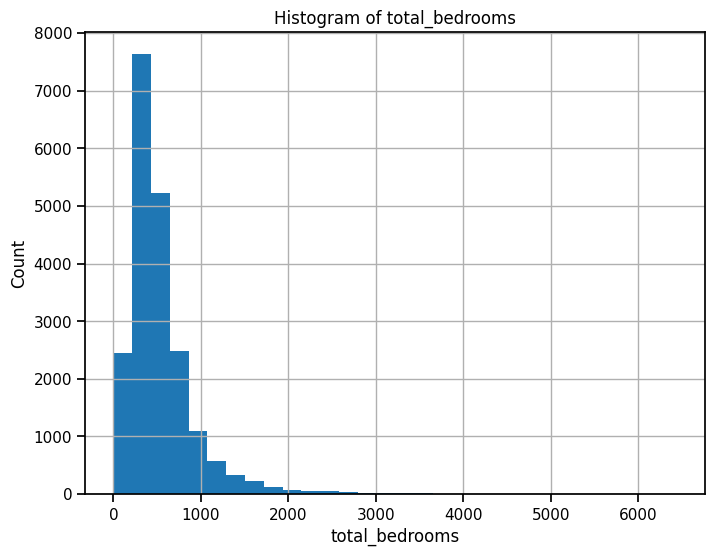

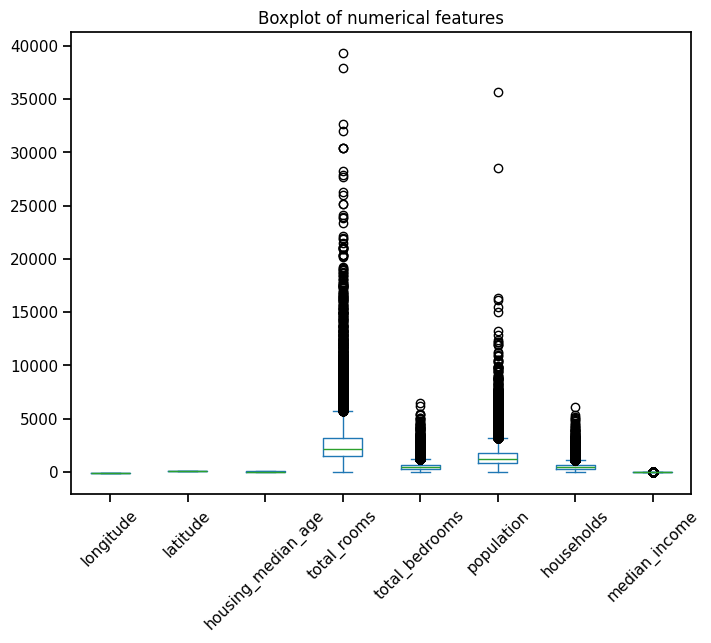

In [4]:
counts = pd.Series(y_full).value_counts().sort_index()
display(pd.DataFrame({
    "target": counts.index,
    "number": counts.values,
    "share": (counts.values / counts.values.sum())
}))

display(X_full.describe().T)

missing_summary = pd.DataFrame({
    "missing_count": X_full.isna().sum(),
    "missing_percent": (X_full.isna().mean() * 100).round(2)
}).sort_values("missing_percent", ascending=False)

display(missing_summary)

X_full["total_bedrooms"].hist(bins=30, figsize=(8, 6))
plt.title("Histogram of total_bedrooms")
plt.xlabel("total_bedrooms")
plt.ylabel("Count")
plt.show()

X_full.select_dtypes(include="number").plot(kind="box", figsize=(8, 6))
plt.title("Boxplot of numerical features")
plt.xticks(rotation=45)
plt.show()

### EDA Summary
The EDA confirmed that a binary target was created based on the top 20% of median house values, resulting in an approximate 80/20 class distribution.  

The feature total_bedrooms contains about 1% missing values. Since the variable is numerically skewed, median imputation is considered an appropriate and robust strategy.  

The boxplots of numerical features reveal skewed distributions, large variation in raw totals, and several extreme values. As many features represent aggregated totals, this motivates the creation of ratio-based features (e.g., per household measures) in the next step.

## Feature Engineering

In [5]:
df["rooms_per_household"] = df["total_rooms"] / df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"] / df["total_rooms"]
df["population_per_household"] = df["population"] / df["households"]

X_eng = df.drop(columns=["median_house_value"])

print(f"X rows:", X_eng.shape[0], "X columns:", X_eng.shape[1],"\ny rows:", y_full.shape[0])

display(X_eng.describe().T)

X rows: 20640 X columns: 12 
y rows: 20640


,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
housing_median_age,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
total_rooms,20640.0,2635.763081,2181.615252,2.000000,1447.750000,2127.000000,3148.000000,39320.000000
total_bedrooms,20433.0,537.870553,421.385070,1.000000,296.000000,435.000000,647.000000,6445.000000
population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
households,20640.0,499.539680,382.329753,1.000000,280.000000,409.000000,605.000000,6082.000000
median_income,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
rooms_per_household,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
bedrooms_per_room,20433.0,0.213039,0.057983,0.100000,0.175427,0.203162,0.239821,1.000000


## Train / Validation / Test Split

In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X_eng, y_full,
    test_size=0.40,
    random_state=42,
    stratify=y_full
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

print ("\nClass distribution in train:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in validation:")
print(y_val.value_counts(normalize=True))
print("\nClass distribution in test:")
print(y_test.value_counts(normalize=True))

Train: (12384, 12) (12384,)
Validation: (4128, 12) (4128,)
Test: (4128, 12) (4128,)

Class distribution in train:
high_value
0    0.799903
1    0.200097
Name: proportion, dtype: float64

Class distribution in validation:
high_value
0    0.799903
1    0.200097
Name: proportion, dtype: float64

Class distribution in test:
high_value
0    0.799903
1    0.200097
Name: proportion, dtype: float64


## Validating Feature Engineering after Split

In [7]:
train_df = pd.concat([X_train, y_train], axis=1)
corr_target = train_df.corr(numeric_only=True)["high_value"].sort_values(ascending=False)
print(corr_target)

high_value                  1.000000
median_income               0.547326
rooms_per_household         0.158246
housing_median_age          0.101428
total_rooms                 0.095064
households                  0.022043
total_bedrooms              0.014834
population_per_household   -0.017730
population                 -0.050882
latitude                   -0.058320
longitude                  -0.061977
bedrooms_per_room          -0.223131
Name: high_value, dtype: float64


### Validating Feature Engineering Summary
The correlation analysis (train set) shows that median_income has the strongest positive relationship with the target. Engineered features such as rooms per household show stronger association than raw totals, supporting the feature engineering step.

## Help Function for Evaluating Classification

In [8]:
def evaluate_classification(y_true, y_pred) -> dict:
   
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
    }

## Preprocessing
For the non-numerical feature ocean proximity OneHotEncoder is used.  
Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

In [9]:
numeric_features = X_train.select_dtypes(include="number").columns
categorical_features = X_train.select_dtypes(exclude="number").columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

## Dummy Baseline

Validation Metrics for Baseline:


,accuracy,precision,recall,f1
Baseline,0.799903,0.0,0.0,0.0


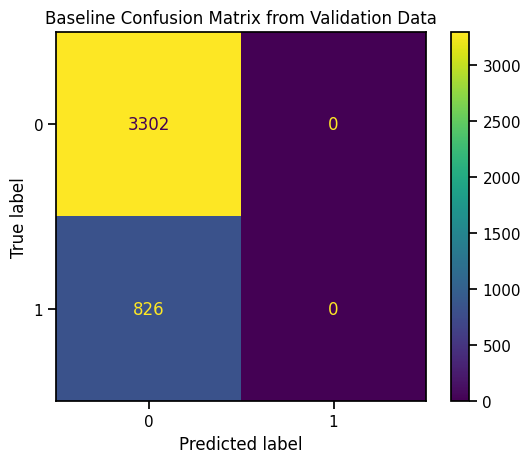

In [10]:
baseline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent", random_state=42))
])

baseline.fit(X_train, y_train)

y_pred_base_val = baseline.predict(X_val)

print("Validation Metrics for Baseline:")
baseline_metrics_val = evaluate_classification(y_val, y_pred_base_val)

baseline_metrics_df = (
    pd.DataFrame(baseline_metrics_val, index=["Baseline"])
    .round(6)
)

display(baseline_metrics_df)

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_base_val)
plt.title("Baseline Confusion Matrix from Validation Data")
plt.show()

## Training Models on Train Data


In [11]:
models = {}

logreg = Pipeline(steps=[
    ("preprocess", preprocess), 
    ("model", LogisticRegression(
        max_iter=5000,
        random_state=42
    ))
])

models["LogReg"] = logreg

knn = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", KNeighborsClassifier())
])

models["KNN"] = knn

tree = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DecisionTreeClassifier(
        random_state=42,
        max_depth=3))
])

models["Tree"] = tree

ranfor = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

models["Random Forest"] = ranfor

rows = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    rows.append({"model": name, **evaluate_classification(y_val, y_pred_val)})

results_val = pd.DataFrame(rows).sort_values("recall", ascending=False)
results_val

,model,accuracy,precision,recall,f1
3,Random Forest,0.917878,0.859675,0.704600,0.774451
0,LogReg,0.890262,0.790047,0.615012,0.691627
1,KNN,0.885174,0.789474,0.581114,0.669456
2,Tree,0.854893,0.844985,0.336562,0.481385


## Confusion Matrix for Chosen Model Random Forest

Validation Metrics for Random Forest:


,accuracy,precision,recall,f1
Random Forest (val),0.917878,0.859675,0.7046,0.774451


Classification Report for Random Forest (val):


,precision,recall,f1-score,support
not_high_value,0.929296,0.971230,0.949800,3302.000000
high_value,0.859675,0.704600,0.774451,826.000000
accuracy,0.917878,0.917878,0.917878,0.917878
macro avg,0.894485,0.837915,0.862126,4128.000000
weighted avg,0.915365,0.917878,0.914713,4128.000000


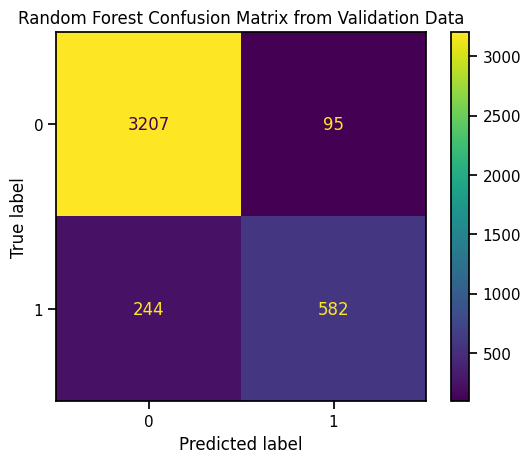

In [12]:
best_model = models["Random Forest"]
best_model.fit(X_train, y_train)

y_pred_val = best_model.predict(X_val)

print("Validation Metrics for Random Forest:")
model_metrics_val = evaluate_classification(y_val, y_pred_val)

model_metrics_df = (
    pd.DataFrame(model_metrics_val, index=["Random Forest (val)"])
    .round(6)
)

display(model_metrics_df)


print("Classification Report for Random Forest (val):")

report = classification_report(
    y_val,
    y_pred_val,
    target_names=target_names,
    output_dict=True
)

report_df = pd.DataFrame(report).T.round(6)
display(report_df)

ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val)
plt.title("Random Forest Confusion Matrix from Validation Data")
plt.show()

## Model Selection

Random Forest was selected based on highest recall on validation data. The model achives a recall of just over 70% meaning that about 30% of the high-value areas are missed. While it is a significant impovement to the baseline, minimizing false negatives is more important than minimizing false positives. 

## Cross Validation

In [13]:
chosen_model_name = "Random Forest"
print ("Tuning:", chosen_model_name)

param_grid = {
    "model__n_estimators": [200, 500],
    "model__max_depth": [None, 20],
    "model__min_samples_leaf": [1, 5],
    "model__max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=models[chosen_model_name],
    param_grid=param_grid,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_summary = pd.DataFrame(
    {**grid.best_params_, "cv_recall": grid.best_score_},
    index=["Best Random Forest (CV)"]
)

display(best_summary.round(6))

best_model = grid.best_estimator_

Tuning: Random Forest


,model__max_depth,model__max_features,model__min_samples_leaf,model__n_estimators,cv_recall
Best Random Forest (CV),20,sqrt,1,200,0.719523


## Precision Recall Curve

Average precision (val): 0.874699


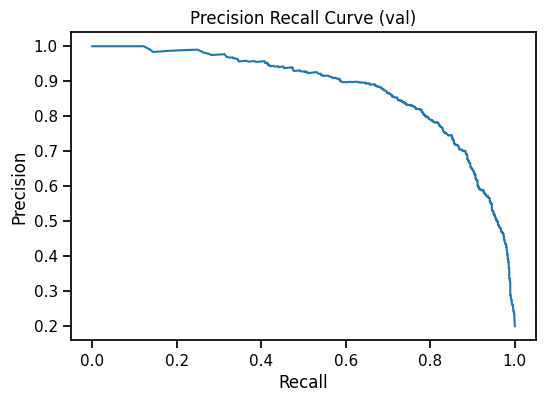

In [14]:
proba_val = best_model.predict_proba(X_val)[:, 1] 

precision, recall, thresholds = precision_recall_curve(y_val, proba_val)

ap = average_precision_score(y_val, proba_val)
print(f"Average precision (val): {ap:.6f}")

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(recall, precision)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision Recall Curve (val)")
plt.show()


## Threshold

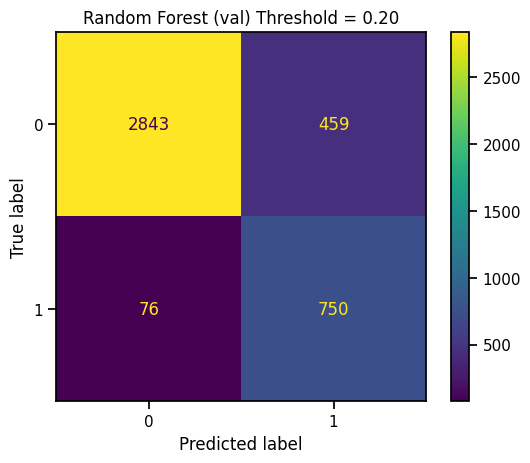

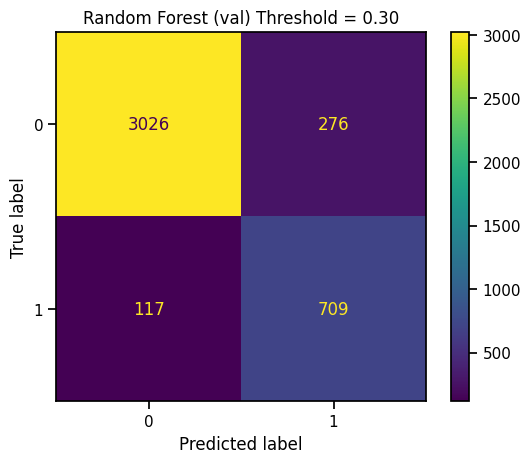

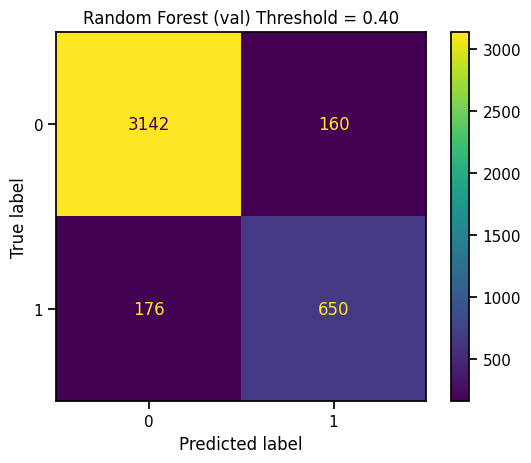

,accuracy,precision,recall,f1
Random Forest (val) Threshold,,,,
0.2,0.8704,0.6203,0.9080,0.7371
0.3,0.9048,0.7198,0.8584,0.7830
0.4,0.9186,0.8025,0.7869,0.7946


,TN,FP,FN,TP
Random Forest (val) Threshold,,,,
0.2,2843,459,76,750
0.3,3026,276,117,709
0.4,3142,160,176,650


In [15]:
thrs_to_test = [0.2, 0.3, 0.4]

metric_rows = []
cm_rows = []

for thr in thrs_to_test:
    y_pred_thr= (proba_val >= thr).astype(int)
    metric_rows.append({"Random Forest (val) Threshold": thr, **evaluate_classification(y_val, y_pred_thr)})

    cm = confusion_matrix(y_val, y_pred_thr)
    tn, fp, fn, tp =cm.ravel()

    cm_rows.append({"Random Forest (val) Threshold": thr, "TN": tn, "FP": fp, "FN": fn, "TP": tp})

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Random Forest (val) Threshold = {thr:.2f}")
    plt.show()

metrics_df = (pd.DataFrame(metric_rows).set_index("Random Forest (val) Threshold").round(4))

display(metrics_df)

cm_df = (
    pd.DataFrame(cm_rows)
      .set_index("Random Forest (val) Threshold")
)

display(cm_df)

### Cross Validation, Precision Recall Curve and Threshold Summary
Cross validation improved the models recall from aproximatelly 0.70 to 0.72.

The recall precision curve shows an average precision of 0.878 which indicates a strong separability between high-value and non-high-value areas. It also show a precision of 0.85 - 0.90 for a recall aroun 0.70. When recall aproaches 1.0 the precision drops rapidly.

Lowering the classification threshold increases recall but also increases false positives. Since the primary business objective is to avoid missing high-value areas, recall is prioritized over precision. A threshold of 0.30 provides a reasonable balance, significantly reducing false negatives compared to 0.40 while avoiding the excessive false positives observed at 0.20.



In [16]:
rows = []

y_pred_dummy = baseline.predict(X_val)
rows.append({
    "model": "Dummy (most_frequent)",
    **evaluate_classification(y_val, y_pred_dummy)
})

y_pred_rf_default = best_model.predict(X_val)
rows.append({
    "model": "Random Forest (thr=0.50)",
    **evaluate_classification(y_val, y_pred_rf_default)
})

THRESHOLD = 0.30
proba_val = best_model.predict_proba(X_val)[:, 1]
y_pred_rf_thr = (proba_val >= THRESHOLD).astype(int)

rows.append({
    "model": f"Random Forest (thr={THRESHOLD:.2f})",
    **evaluate_classification(y_val, y_pred_rf_thr)
})


comparison_df = (
    pd.DataFrame(rows)
      .set_index("model")
      .round(4)
)

display(comparison_df)

,accuracy,precision,recall,f1
model,,,,
Dummy (most_frequent),0.7999,0.0000,0.0000,0.0000
Random Forest (thr=0.50),0.9181,0.8664,0.6985,0.7735
Random Forest (thr=0.30),0.9048,0.7198,0.8584,0.7830


## Refit on Train and Validation Data + Final Test

Test Metrics for Best Model:


,accuracy,precision,recall,f1
"Best Model (test, thr=0.30)",0.909157,0.731282,0.863196,0.791782


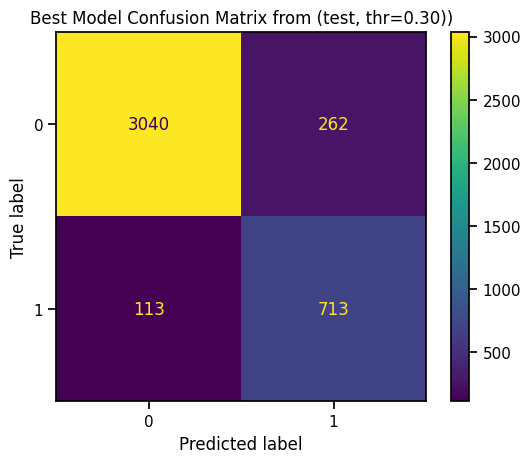

In [17]:
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

best_model.fit(X_trainval, y_trainval)

THRESHOLD = 0.30

proba_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test_thr = (proba_test >= THRESHOLD).astype(int)

print("Test Metrics for Best Model:")
best_model_metrics_test = evaluate_classification(y_test, y_pred_test_thr)

best_model_metrics_df = (
    pd.DataFrame(best_model_metrics_test, index=[f"Best Model (test, thr={THRESHOLD:.2f})"])
    .round(6)
)

display(best_model_metrics_df)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_thr)
plt.title(f"Best Model Confusion Matrix from (test, thr={THRESHOLD:.2f}))")
plt.show()

## Kmeans

In [18]:
cluster_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Säkerställ att ratio-kolumnerna är numeriska
ratio_cols = ["rooms_per_household", "bedrooms_per_room", "population_per_household"]
X_eng[ratio_cols] = X_eng[ratio_cols].apply(pd.to_numeric, errors="coerce")

X_numeric = X_eng.select_dtypes(include=["number"])

X_scaled = cluster_preprocess.fit_transform(X_numeric)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns)

display(X_scaled_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-8.603626e-15,1.000024,-2.385992,-1.113209,0.538914,0.778496,2.625280
latitude,20640.0,2.247298e-15,1.000024,-1.447568,-0.796789,-0.642287,0.972957,2.958068
housing_median_age,20640.0,4.406467e-17,1.000024,-2.196180,-0.845393,0.028646,0.664310,1.856182
total_rooms,20640.0,2.203233e-17,1.000024,-1.207283,-0.544570,-0.233210,0.234803,16.815580
total_bedrooms,20640.0,-8.812933e-17,1.000024,-1.277688,-0.571887,-0.242831,0.253733,14.087789
population,20640.0,-1.101617e-17,1.000024,-1.256123,-0.563809,-0.229132,0.264495,30.250330
households,20640.0,7.160508e-17,1.000024,-1.303984,-0.574229,-0.236816,0.275843,14.601520
median_income,20640.0,5.508083e-17,1.000024,-1.774299,-0.688119,-0.176795,0.459306,5.858286
rooms_per_household,20640.0,7.711317e-17,1.000024,-1.852319,-0.399450,-0.080785,0.251961,55.163236
bedrooms_per_room,20640.0,6.169053e-16,1.000024,-1.957424,-0.645288,-0.169457,0.456391,13.640992


In [24]:
K_MIN, K_MAX = 2, 8
rows = []
for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = km.fit_predict(X_scaled)
    rows.append({
        "K": k,
        "inertia": km.inertia_,
        "silhouette": silhouette_score(X_scaled, labels_k),
    })
scores = pd.DataFrame(rows)

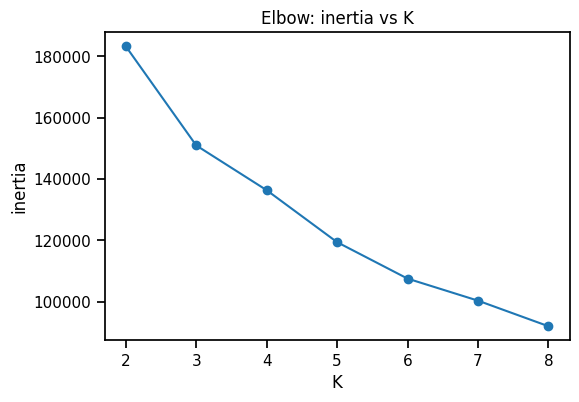

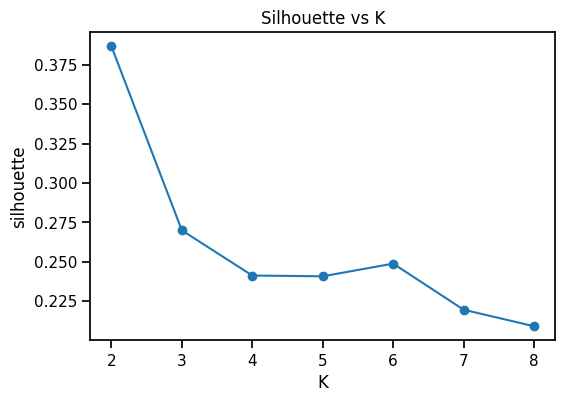

In [25]:
plt.figure(figsize=(6,4))
plt.plot(scores["K"], scores["inertia"], marker="o")
plt.title("Elbow: inertia vs K")
plt.xlabel("K"); plt.ylabel("inertia")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(scores["K"], scores["silhouette"], marker="o")
plt.title("Silhouette vs K")
plt.xlabel("K"); plt.ylabel("silhouette")
plt.show()

In [36]:
K_final = 2
kmeans_final = KMeans(n_clusters=K_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

print(pd.Series(cluster_labels).value_counts().sort_index())

0    18240
1     2400
Name: count, dtype: int64


In [37]:
X_raw_df = X_numeric.copy()
X_raw_df["cluster"] = cluster_labels

X_z_df = X_scaled_df.copy()
X_z_df["cluster"] = cluster_labels

sizes = X_raw_df["cluster"].value_counts().sort_index().rename("n_areas")

profiles_raw = X_raw_df.groupby("cluster").median(numeric_only=True).join(sizes)
display(profiles_raw)

profiles_z = X_z_df.groupby("cluster").median(numeric_only=True).join(sizes)
display(profiles_z)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,n_areas
cluster,,,,,,,,,,,,
0,-118.57,34.28,31.0,1960.5,400.0,1072.0,377.0,3.50000,5.216028,0.203390,2.824303,18240
1,-118.36,34.15,17.0,5827.5,1196.0,3037.5,1099.5,3.84325,5.335824,0.201645,2.782776,2400


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,bedrooms_per_room,population_per_household,n_areas
cluster,,,,,,,,,,,,
0,0.498983,-0.632923,0.187562,-0.309532,-0.319134,-0.312139,-0.320516,-0.195113,-0.08608,-0.169457,-0.023720,18240
1,0.603801,-0.693788,-0.924851,1.463051,1.564592,1.423502,1.569260,-0.014434,-0.03766,-0.187752,-0.027719,2400


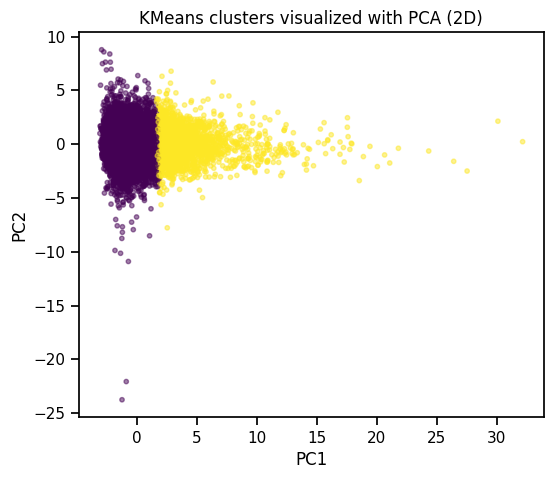

In [38]:
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, s=10, alpha=0.5)
plt.title("KMeans clusters visualized with PCA (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [40]:
cluster_df = X_eng.copy()
cluster_df["cluster"] = cluster_labels

pd.crosstab(cluster_df["cluster"], cluster_df["ocean_proximity"])

ocean_proximity,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
cluster,,,,,
0,8005,5754,5,2093,2383
1,1131,797,0,197,275


In [41]:
pd.crosstab(
    cluster_df["cluster"], 
    cluster_df["ocean_proximity"],
    normalize="index"
)

ocean_proximity,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
cluster,,,,,
0,0.438871,0.315461,0.000274,0.114748,0.130647
1,0.471250,0.332083,0.000000,0.082083,0.114583
